In [2]:
from datetime import datetime as dt
import numpy as np
import torch

from matplotlib import pyplot as plt
from torch.utils.data import random_split

from preconditioners import settings
from preconditioners.datasets import generate_true_parameter, CenteredLinearGaussianDataset, generate_true_parameter, generate_c
from preconditioners.utils import MLP, SLP
from preconditioners.optimizers import PrecondGD
import preconditioners


In [3]:
# Same as in linear_kernel_variance_30102022.ipynb (and if it is not, it should be)

from preconditioners.datasets import generate_c, generate_centered_linear_gaussian_data, generate_true_parameter, generate_W_star

def kernel_variance_interpolator(features : np.ndarray, P : np.ndarray, F : np.ndarray, sigma2 : np.float64) -> np.float64:
    ''' Given Nxp feature matrix {features}, pxp symmetric preconditioner P and pxp true covariance matrix F, and the signal to noise ratio, this function returns the variance component of the risk 
    of the interpolator which is the limit of PGD which uses preconditioner P.'''
    assert features.shape[1] == P.shape[0] == P.shape[1] == F.shape[0] == F.shape[1]
    assert np.linalg.norm(P - P.T) < 1e-9, 'P must be symmetric.'

    empirical_NTK = features.dot(P).dot(features.T)
    empirical_NTK_inv = np.linalg.inv(empirical_NTK)
    auxi_matrix = features.dot(P).dot(F).dot(P).dot(features.T)

    return sigma2 * np.trace(empirical_NTK_inv.dot(auxi_matrix).dot(empirical_NTK_inv))

In [4]:
# Adapted CheckEigenvalues class from src/preconditioners/eigenvalues/kernel_eigenvalues.py
# with the linear gaussian dataset

class Initializer:
    def __init__(self,
                width,
                depth,
                d,
                lam,
                train_size,
                extra_size,
                sigma2,
                r2,
                regime,
                ro,
                ):
        # Network parameters
        self.width = width
        self.depth = depth
        self.d = d
        self.damping = lam * np.sqrt(self.d) if self.depth == 1 else lam * self.width

        # Dataset parameters
        self.train_size = train_size
        self.extra_size = extra_size
    
        w_star = generate_true_parameter(self.d, r2, m=np.eye(self.d))
        c = generate_c(ro, regime=regime, d=self.d) if self.depth > 1 else generate_c(ro, regime=regime, d=self.d) * np.sqrt(self.d) # we don't need to multiply by sqrt(d) if d > 1 because there c is not the Fisher
        dataset = CenteredLinearGaussianDataset(w_star, c, n=self.train_size + self.extra_size, d=self.d, sigma2=sigma2)

        self.train_dataset, self.extra_dataset = random_split(dataset, [self.train_size, self.extra_size])
        self.labeled_data = self.train_dataset[:][0].double().to(settings.DEVICE)
        self.unlabeled_data = self.extra_dataset[:][0].double().to(settings.DEVICE)

    def create_model(self):
        std = 1/ np.sqrt(self.width)

        # Create model and optimizer
        if self.depth == 1:
            self.model = SLP(in_channels=self.d).double().to(settings.DEVICE)
        else:
            self.model = MLP(in_channels=self.d, num_layers=self.depth, hidden_channels=self.width, std=std).double().to(settings.DEVICE)
        self.optimizer = PrecondGD(self.model, lr=1e-2, labeled_data=self.labeled_data, unlabeled_data=self.unlabeled_data, verbose=False, damping=self.damping)

    def get_features_and_p_inv(self):
        self.create_model()
        p_inv = self.optimizer._compute_p_inv()
        grad = self.optimizer._compute_grad_of_data(self.labeled_data)
        return grad, p_inv

In [6]:
## Test that I get the same results if the MLP is a linear network.

N = 20
sigma2 = 2
ro = 0.9
n_ds = 10
n_lams = 10
ds = [int(x) for x in np.linspace(2*N,65*N,n_ds)]
ams = np.linspace(0.1,10,n_lams)
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)

d = 50
lam = 0.1

# linear
np.random.seed(0)
damping = lam * np.sqrt(d)
c = np.sqrt(d) * generate_c(ro=ro, regime='autoregressive', d=d)
X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
P_damped = np.linalg.inv(c + damping*np.eye(d))
P_ngd = np.linalg.inv(c)

# get it through the initializer
i = Initializer(width = 1,
                depth = 1,
                d = d,
                lam = lam,
                train_size = N,
                extra_size = N+10000,
                sigma2 = sigma2,
                r2 = 1,
                regime = 'autoregressive',
                ro = ro)

grad, F_inv = i.get_features_and_p_inv()

# good enough
print(np.linalg.norm(F_inv - P_damped)/np.sqrt(F_inv.shape[0]))

0.019751644785532183


In [18]:
import matplotlib.pyplot as plt
import numpy as np

N = 20
d = 25
sigma2 = 2
ro = 0.9
n_ns = 6
n_lams = 2
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))    

ns = [int(x) for x in np.linspace(2*N,6*N,n_ns)]
ams = np.linspace(0.1,10,n_lams)
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)
dampings = []

k = 0
for i in range(n_ns):
    for j in range(n_lams):
        k = k+1
        print(f'iteration {k} of {n_ns*n_lams}')
        n = ns[i]
        lam = lams[j]
        damping = lam * n # TODO: check if multiplying by n is correct
        dampings.append(damping)
        

        params = {
            'width' : n,
            'depth' : 2,
            'd' : d,
            'lam' : lam,
            'train_size' : N,
            'extra_size' : N+10000,
            'sigma2' : sigma2,
            'r2' : 1,
            'regime' : 'autoregressive',
            'ro' : ro
        }
        i_damped = Initializer(**params)
        features, p_inv_damped = [x.numpy() for x in i_damped.get_features_and_p_inv()]
        
        params['lam'] = 1e-7 # not zero to avoid division by zero

        i_ngd = Initializer(**params)
        _, p_inv_ngd = [x.numpy() for x in i_ngd.get_features_and_p_inv()]
        
        # TODO: fix passing F not np.linalg.inv(p_inv_ngd)
        variances_damped[i, j] = kernel_variance_interpolator(features=features, P=p_inv_damped, F=np.linalg.inv(p_inv_ngd), sigma2=sigma2) 
        variances_ngd[i, j] = kernel_variance_interpolator(features=features, P=p_inv_ngd, F=np.linalg.inv(p_inv_ngd), sigma2=sigma2)
        variances_diff = variances_damped - variances_ngd

iteration 1 of 12


/Users/eduardoravkin/Dropbox/My Mac (Eduard’s MacBook Pro)/Desktop/ml_research/PhD/preconditioners/src/preconditioners/datasets.py:153: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')
/opt/anaconda3/envs/preconditioners_new/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


iteration 2 of 12
iteration 3 of 12


KeyboardInterrupt: 

In [10]:
lams

array([10.        ,  0.31622777,  0.01      ])

In [11]:
print(variances_diff[0,:])
print(variances_diff[-1,:])


[ 7.0065592  14.65235072  8.68888996]
[26.94521348 17.6170947  11.36904122]


In [16]:
print(variances_diff[:,0])
print(variances_diff[:,1])
print(variances_diff[:,2])

[ 7.0065592  15.16918241 26.94521348]
[14.65235072 15.77779654 17.6170947 ]
[ 8.68888996 22.82022661 11.36904122]


<AxesSubplot: >

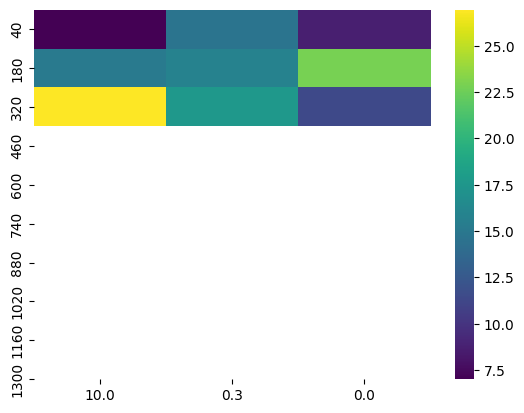

In [13]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ds)

In [ ]:
#######################################################################################################
#######################################################################################################


In [61]:
# TODO: Triple check that we are computing the inverse well now and that we were doing it wrong before. Because the tests were passing before.

In [62]:
c[:3,:3]

array([[7.07106781, 6.36396103, 5.72756493],
       [6.36396103, 7.07106781, 6.36396103],
       [5.72756493, 6.36396103, 7.07106781]])

In [63]:
(c + damping*np.eye(d))[:3,:3]

array([[7.77817459, 6.36396103, 5.72756493],
       [6.36396103, 7.77817459, 6.36396103],
       [5.72756493, 6.36396103, 7.77817459]])

In [64]:
np.linalg.inv(c+ damping*np.eye(d))[:3,:3]

array([[ 0.40672876, -0.26077797, -0.06749992],
       [-0.26077797,  0.573929  , -0.21749976],
       [-0.06749992, -0.21749976,  0.58513116]])

In [18]:
import torch
torch.cholesky_inverse(torch.from_numpy(c+ damping*np.eye(d)))[:3,:3]

tensor([[ 0.0352, -0.0173, -0.0002],
        [-0.0173,  0.0352, -0.0173],
        [-0.0002, -0.0173,  0.0352]], dtype=torch.float64)

In [39]:
import torch
torch.cholesky_inverse(torch.cholesky(torch.from_numpy(c+ damping*np.eye(d))))[:3,:3]

tensor([[ 0.1522, -0.1304, -0.0057],
        [-0.1304,  0.2640, -0.1256],
        [-0.0057, -0.1256,  0.2642]], dtype=torch.float64)

In [40]:
np.linalg.inv(c+ damping*np.eye(d))[:3,:3]

array([[ 0.15224482, -0.13042363, -0.00565121],
       [-0.13042363,  0.26397487, -0.1255824 ],
       [-0.00565121, -0.1255824 ,  0.26418464]])

In [41]:
P_damped[:3,:3]

array([[ 0.15224482, -0.13042363, -0.00565121],
       [-0.13042363,  0.26397487, -0.1255824 ],
       [-0.00565121, -0.1255824 ,  0.26418464]])

In [42]:
F_inv.numpy()[:3,:3]

array([[ 1.73584905e-03, -8.49996340e-04, -8.67206609e-06],
       [-8.49996340e-04,  1.73288370e-03, -8.62042779e-04],
       [-8.67206609e-06, -8.62042779e-04,  1.76788253e-03]])